# Bot Detector

This notebook builds a **bot detector** using the provided datasets:
- **Posts & users**: `dataset.posts&users.*.json` (posts with `author_id`, text, timestamps)
- **Bot labels**: `dataset.bots.*.txt` (one user UUID per line = bot)

We'll load the data, engineer features from user/post behavior, and train a classifier to predict bot vs human.

---

**Methodological note.** We take a classical feature-engineering + gradient-boosting approach; this provides an interpretable baseline and downstream inputs for the GNN (BotRGCN). Features span behavioral, temporal, and profile-level signals—each chosen for its discriminative power in prior bot-detection literature.

In [1]:
pip install pandas numpy scikit-learn xgboost matplotlib

Python(5260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


## 1. Setup

In [2]:
import json
import os
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np


## 2. Load data

In [3]:
DATA_DIR = Path(".")

def load_bot_ids(dataset_id: int) -> set:
    """Load bot user IDs from dataset.bots.<id>.txt"""
    path = DATA_DIR / f"dataset.bots.{dataset_id}.txt"
    if not path.exists():
        return set()
    with open(path) as f:
        return set(line.strip() for line in f if line.strip())

def load_posts_and_users(dataset_id: int) -> dict:
    """Load posts & users JSON for a given dataset id."""
    path = DATA_DIR / f"dataset.posts&users.{dataset_id}.json"
    with open(path) as f:
        return json.load(f)

# Example: load dataset 30
dataset_id = 30
bot_ids = load_bot_ids(dataset_id)
data = load_posts_and_users(dataset_id)
posts = data["posts"]
users = data["users"]

print(f"Bot IDs loaded: {len(bot_ids)}")
print(f"Posts loaded: {len(posts)}")
print(f"Sample bot IDs: {list(bot_ids)[:3]}")

Bot IDs loaded: 66
Posts loaded: 7528
Sample bot IDs: ['962cbe6b-cbb6-467d-b587-5ce2c90a7c22', '595e7e6a-a2f9-46d2-9239-3b62e052d442', '7bf9d921-e407-4da3-b1bb-7de1175271e3']


## 3. Build user-level features

In [4]:
def extract_user_features(posts: list, users: list, bot_ids: set) -> pd.DataFrame:
    """Aggregate posts per author and compute simple features + bot label."""
    by_author = defaultdict(list)
    for p in posts:
        by_author[p["author_id"]].append(p)


    rows = []
    for author_id, author_posts in by_author.items():
        texts = [p["text"] for p in author_posts]
        created = [pd.to_datetime(p["created_at"]) for p in author_posts]

        # Simple features (expand as needed)
        row = {
            "author_id": author_id,
            "post_count": len(author_posts),
            "avg_text_length": np.mean([len(t) for t in texts]),
            "unique_langs": len(set(p.get("lang", "") for p in author_posts)),
            "has_url_ratio": np.mean([1 if "http" in t else 0 for t in texts]),
            "is_bot": 1 if author_id in bot_ids else 0,
        }
        if len(created) > 1:
            created.sort()
            gaps = np.diff(created).astype("timedelta64[s]").astype(float)
            row["avg_post_gap_seconds"] = np.mean(gaps)
            row["min_post_gap_seconds"] = np.min(gaps)
        else:
            row["avg_post_gap_seconds"] = np.nan
            row["min_post_gap_seconds"] = np.nan
        rows.append(row)

    return pd.DataFrame(rows)

df = extract_user_features(posts, users, bot_ids)
df.head(10)

,author_id,post_count,avg_text_length,unique_langs,has_url_ratio,is_bot,avg_post_gap_seconds,min_post_gap_seconds
0,196682f6-c29c-881b-9030-f71c23e29c85,39,141.230769,1,0.948718,0,4545.289474,25.0
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,29,60.551724,1,0.068966,0,5748.535714,10.0
2,865ea40e-92f1-b149-8b07-b00be16e7df6,59,151.254237,1,0.694915,0,2947.965517,0.0
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,37,48.756757,1,0.000000,0,4768.472222,12.0
4,cb1ae84d-c526-b508-af03-312ec7c55648,14,93.000000,1,0.285714,0,13171.384615,42.0
5,1843a95c-b041-a12e-bc12-fd8726031728,28,57.071429,1,0.285714,0,6393.518519,23.0
6,14533de1-507a-8ab8-8c48-c25fc2843eef,47,108.042553,1,0.957447,0,3489.260870,42.0
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,20,124.750000,1,0.200000,0,9052.789474,26.0
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,38,100.236842,1,0.973684,0,4630.594595,0.0
9,94ab6deb-d359-8353-be40-0ffa1113abfe,12,127.083333,1,0.833333,0,14984.000000,80.0


### Feature: Levenshtein Distance (username vs display name)

Measures how different the screen name (`username`) is from the display name (`name`).
Bots often have auto-generated usernames that differ significantly from their display name.

*Profile coherence is a weak but interpretable signal—humans tend toward consistent self-presentation; automated accounts often reuse templates or random suffixes.*

In [5]:
def levenshtein_distance(a: str, b: str) -> int:
    """Edit distance between two strings (insertions, deletions, substitutions)."""
    if len(a) < len(b):
        a, b = b, a
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a):
        curr = [i + 1]
        for j, cb in enumerate(b):
            curr.append(min(prev[j] + (0 if ca == cb else 1), prev[j + 1] + 1, curr[j] + 1))
        prev = curr
    return prev[-1]

# Build a lookup: author_id -> levenshtein distance between username and display name
user_lev = {}
for u in users:
    uname = u.get("username", "") or ""
    dname = u.get("name", "") or ""
    user_lev[u["id"]] = levenshtein_distance(uname.lower(), dname.lower())

df["levenshtein_name_dist"] = df["author_id"].map(user_lev)

df[["author_id", "levenshtein_name_dist"]].head(10)

,author_id,levenshtein_name_dist
0,196682f6-c29c-881b-9030-f71c23e29c85,1
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,6
2,865ea40e-92f1-b149-8b07-b00be16e7df6,14
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,32
4,cb1ae84d-c526-b508-af03-312ec7c55648,1
5,1843a95c-b041-a12e-bc12-fd8726031728,10
6,14533de1-507a-8ab8-8c48-c25fc2843eef,25
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,17
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,6
9,94ab6deb-d359-8353-be40-0ffa1113abfe,11


### Feature: Digit Density (username)

Fraction of characters in the username that are digits.
Bot-generated screen names often contain more numbers (e.g. `user83729401`).

*Classic heuristic from Twitter/X bot studies; correlates with automated account creation.*

In [6]:
def digit_density(s: str) -> float:
    """Fraction of characters in s that are digits."""
    if not s:
        return 0.0
    return sum(ch.isdigit() for ch in s) / len(s)

# Build lookup: author_id -> digit density of username
user_digit_density = {
    u["id"]: digit_density(u.get("username", "")) for u in users
}

df["digit_density"] = df["author_id"].map(user_digit_density)

df[["author_id", "digit_density"]].head(10)

,author_id,digit_density
0,196682f6-c29c-881b-9030-f71c23e29c85,0.000000
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,0.250000
2,865ea40e-92f1-b149-8b07-b00be16e7df6,0.142857
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,0.000000
4,cb1ae84d-c526-b508-af03-312ec7c55648,0.000000
5,1843a95c-b041-a12e-bc12-fd8726031728,0.000000
6,14533de1-507a-8ab8-8c48-c25fc2843eef,0.000000
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,0.000000
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,0.000000
9,94ab6deb-d359-8353-be40-0ffa1113abfe,0.250000


### Feature: Inter-Arrival Time (IAT) Entropy

Shannon entropy of the binned inter-arrival times between consecutive posts.
Low entropy = very regular/periodic posting (bot-like). High entropy = varied timing (more human-like).

*Entropy over binned IATs captures regularity without assuming a parametric distribution (e.g. Poisson).*

In [7]:
from scipy.stats import entropy as scipy_entropy

def iat_entropy(timestamps: list, n_bins: int = 20) -> float:
    """
    Compute Shannon entropy of binned inter-arrival times.
    Requires at least 3 posts (2 gaps) to be meaningful.
    """
    if len(timestamps) < 3:
        return np.nan
    ts = sorted(timestamps)
    gaps = np.diff(ts).astype("timedelta64[s]").astype(float)
    # Bin the gaps into n_bins equal-width bins
    counts, _ = np.histogram(gaps, bins=n_bins)
    # Normalize to probabilities (scipy_entropy handles 0s)
    return float(scipy_entropy(counts, base=2))

# Compute per author
by_author = defaultdict(list)
for p in posts:
    by_author[p["author_id"]].append(pd.to_datetime(p["created_at"]))

iat_entropy_map = {
    author_id: iat_entropy(ts_list)
    for author_id, ts_list in by_author.items()
}

df["iat_entropy"] = df["author_id"].map(iat_entropy_map)

df[["author_id", "iat_entropy"]].head(10)

,author_id,iat_entropy
0,196682f6-c29c-881b-9030-f71c23e29c85,0.523588
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,1.232087
2,865ea40e-92f1-b149-8b07-b00be16e7df6,1.070693
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,1.025294
4,cb1ae84d-c526-b508-af03-312ec7c55648,2.141620
5,1843a95c-b041-a12e-bc12-fd8726031728,1.857045
6,14533de1-507a-8ab8-8c48-c25fc2843eef,2.053940
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,1.773214
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,2.244014
9,94ab6deb-d359-8353-be40-0ffa1113abfe,1.672933


### Feature: Burstiness Parameter

**Burstiness** forces the model to distinguish between **Random Noise (Bot Jitter)** and **Clustered Activity (Human Focus)**.

Defined as $B = \frac{\sigma - \mu}{\sigma + \mu}$ where μ and σ are the mean and standard deviation of inter-arrival times between posts.

- **B ≈ -1**: perfectly periodic (very bot-like)
- **B ≈ 0**: Poisson-like random process
- **B ≈ +1**: highly bursty / clustered (human-like focus)

*Standard measure from temporal point-process modeling; complementary to IAT entropy (regularity vs. burstiness).*

In [8]:
def burstiness(timestamps: list) -> float:
    """
    Burstiness B = (σ - μ) / (σ + μ) of inter-arrival times.
    Distinguishes random noise (bot jitter) vs clustered activity (human focus).
    Requires at least 3 posts (2 gaps).
    """
    if len(timestamps) < 3:
        return np.nan
    ts = sorted(timestamps)
    gaps = np.diff(ts).astype("timedelta64[s]").astype(float)
    mu = np.mean(gaps)
    sigma = np.std(gaps, ddof=1)
    if (sigma + mu) == 0:
        return 0.0
    return (sigma - mu) / (sigma + mu)

burstiness_map = {
    author_id: burstiness(ts_list)
    for author_id, ts_list in by_author.items()
}

df["burstiness"] = df["author_id"].map(burstiness_map)

df[["author_id", "burstiness"]].head(10)

,author_id,burstiness
0,196682f6-c29c-881b-9030-f71c23e29c85,0.573157
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,0.409262
2,865ea40e-92f1-b149-8b07-b00be16e7df6,0.478424
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,0.454594
4,cb1ae84d-c526-b508-af03-312ec7c55648,0.234074
5,1843a95c-b041-a12e-bc12-fd8726031728,0.294374
6,14533de1-507a-8ab8-8c48-c25fc2843eef,0.301433
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,0.284817
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,0.266149
9,94ab6deb-d359-8353-be40-0ffa1113abfe,0.281107


### Feature: Activity Vector (24-hour)

A 24-dimensional vector representing the count of tweets in each hour of the day (0-23).
Captures daily posting habits — bots often show unnaturally uniform or concentrated activity patterns.

*Diurnal patterns differ sharply between humans (timezone-dependent) and scripts (uniform or fixed schedules).*

In [9]:
def activity_vector(timestamps: list) -> list:
    """
    Build a 24-element vector counting how many tweets fall in each hour (0-23).
    """
    vec = [0] * 24
    for ts in timestamps:
        vec[ts.hour] += 1
    return vec

# Compute per author and expand into 24 columns (hour_0 .. hour_23)
activity_rows = {}
for author_id, ts_list in by_author.items():
    activity_rows[author_id] = activity_vector(ts_list)

activity_df = pd.DataFrame.from_dict(activity_rows, orient="index",
                                      columns=[f"hour_{h}" for h in range(24)])
activity_df.index.name = "author_id"
activity_df = activity_df.reset_index()

df = df.merge(activity_df, on="author_id", how="left")

# Show a sample
df[["author_id"] + [f"hour_{h}" for h in range(24)]].head(5)

,author_id,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,196682f6-c29c-881b-9030-f71c23e29c85,4,0,0,0,0,0,0,0,0,...,0,0,21,2,0,0,0,0,6,6
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,2,0,5,0,0,0,0,0,0,...,2,5,0,0,0,0,10,5,0,0
2,865ea40e-92f1-b149-8b07-b00be16e7df6,5,3,2,0,0,0,0,0,0,...,1,3,4,6,4,8,4,5,6,8
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,3,0,0,0,0,0,0,0,0,...,12,7,7,3,2,2,0,0,0,1
4,cb1ae84d-c526-b508-af03-312ec7c55648,5,1,0,0,0,0,0,1,0,...,0,2,0,0,0,0,0,0,1,1


### Feature: Language Mismatch

Fraction of a user's posts whose `lang` differs from the dataset-level language.
Bots may post in languages that don't match the dataset's primary language.

In [10]:
dataset_lang = data.get("lang", "en")  # dataset-level language

def lang_mismatch_ratio(author_posts: list, expected_lang: str) -> float:
    """Fraction of posts whose lang differs from the expected dataset language."""
    if not author_posts:
        return 0.0
    mismatches = sum(1 for p in author_posts if p.get("lang", expected_lang) != expected_lang)
    return mismatches / len(author_posts)

# Re-group posts by author (already have by_author from IAT cell, but use raw posts for lang)
by_author_posts = defaultdict(list)
for p in posts:
    by_author_posts[p["author_id"]].append(p)

lang_mismatch_map = {
    author_id: lang_mismatch_ratio(aposts, dataset_lang)
    for author_id, aposts in by_author_posts.items()
}

df["lang_mismatch_ratio"] = df["author_id"].map(lang_mismatch_map)

print(f"Dataset language: '{dataset_lang}'")
df[["author_id", "lang_mismatch_ratio"]].head(10)

Dataset language: 'en'


,author_id,lang_mismatch_ratio
0,196682f6-c29c-881b-9030-f71c23e29c85,0.0
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,0.0
2,865ea40e-92f1-b149-8b07-b00be16e7df6,0.0
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,0.0
4,cb1ae84d-c526-b508-af03-312ec7c55648,0.0
5,1843a95c-b041-a12e-bc12-fd8726031728,0.0
6,14533de1-507a-8ab8-8c48-c25fc2843eef,0.0
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,0.0
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,0.0
9,94ab6deb-d359-8353-be40-0ffa1113abfe,0.0


### Feature: Screen Name Entropy

In [11]:
def screen_name_entropy(screen_name: str, normalize: bool = True) -> float:
    if not screen_name:
        return 0.0
    screen_name = screen_name.strip().lower()
    if not screen_name:
        return 0.0

    counts = {}
    for ch in screen_name:
        counts[ch] = counts.get(ch, 0) + 1

    n = len(screen_name)
    probs = [c / n for c in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs)

    if normalize and len(counts) > 1:
        entropy = entropy / np.log2(len(counts))
    return entropy

# Apply to df
user_entropy_map = {
    u["id"]: screen_name_entropy(u.get("username", "")) for u in users
}
df["screen_name_entropy"] = df["author_id"].map(user_entropy_map)

df[["author_id", "screen_name_entropy"]].head(10)

,author_id,screen_name_entropy
0,196682f6-c29c-881b-9030-f71c23e29c85,0.986660
1,a0299838-ddfa-b9cc-82b0-e334e8b033cc,0.967132
2,865ea40e-92f1-b149-8b07-b00be16e7df6,0.975504
3,d207d0e3-1cd6-9f37-bad3-9b8be102f128,0.971326
4,cb1ae84d-c526-b508-af03-312ec7c55648,0.973215
5,1843a95c-b041-a12e-bc12-fd8726031728,0.954966
6,14533de1-507a-8ab8-8c48-c25fc2843eef,0.988109
7,76c1e83b-31c5-828f-88b6-f7ae58d63a72,0.953352
8,3f3b4b62-74c5-89d0-ae85-79e4f89cbda2,0.982568
9,94ab6deb-d359-8353-be40-0ffa1113abfe,0.978838


## 4. Quick EDA

In [12]:
print("Class balance:")
print(df["is_bot"].value_counts())
print("\nFeature summary:")
df.describe()

Class balance:
is_bot
0    209
1     66
Name: count, dtype: int64

Feature summary:


,post_count,avg_text_length,unique_langs,has_url_ratio,is_bot,avg_post_gap_seconds,min_post_gap_seconds,levenshtein_name_dist,digit_density,iat_entropy,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,lang_mismatch_ratio,screen_name_entropy
count,275.000000,275.000000,275.0,275.000000,275.000000,270.000000,270.000000,275.000000,275.000000,270.000000,...,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.0,275.000000
mean,27.374545,107.301774,1.0,0.463893,0.240000,28320.438567,460.203704,11.290909,0.084866,1.944613,...,1.345455,1.360000,1.440000,1.705455,1.647273,1.661818,2.240000,2.614545,0.0,0.968213
std,21.052110,45.514229,0.0,0.298845,0.427862,92575.019175,1809.553906,7.723017,0.141110,0.791935,...,2.464479,2.192689,2.548622,2.512118,2.404972,2.822970,2.868251,3.636364,0.0,0.024103
min,1.000000,31.333333,1.0,0.000000,0.000000,147.309524,0.000000,0.000000,0.000000,0.270512,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.803114
25%,13.000000,75.941176,1.0,0.235714,0.000000,4657.597426,16.250000,7.000000,0.000000,1.351770,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.957879
50%,20.000000,100.741935,1.0,0.454545,0.000000,8045.095238,52.500000,11.000000,0.000000,1.918768,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.0,0.973976
75%,34.000000,126.865196,1.0,0.680791,0.000000,11812.000000,166.500000,14.000000,0.142857,2.521634,...,2.000000,2.000000,2.000000,2.000000,2.500000,2.000000,3.000000,3.500000,0.0,0.980724
max,95.000000,306.061728,1.0,1.000000,1.000000,531621.084746,23813.000000,47.000000,0.666667,3.941197,...,21.000000,19.000000,26.000000,19.000000,19.000000,28.000000,20.000000,29.000000,0.0,1.000000


## 5. Train XGBoost Classifier

In [13]:
def build_feature_df(dataset_id: int) -> pd.DataFrame:
    """Load one dataset and build the full feature DataFrame (all features)."""
    from scipy.stats import entropy as scipy_entropy

    bot_ids = load_bot_ids(dataset_id)
    data = load_posts_and_users(dataset_id)
    posts = data["posts"]
    users = data["users"]
    dataset_lang = data.get("lang", "en")

    df = extract_user_features(posts, users, bot_ids)

    # Levenshtein
    user_lev = {}
    for u in users:
        uname = u.get("username", "") or ""
        dname = u.get("name", "") or ""
        user_lev[u["id"]] = levenshtein_distance(uname.lower(), dname.lower())
    df["levenshtein_name_dist"] = df["author_id"].map(user_lev)

    # Digit density
    user_digit_density = {u["id"]: digit_density(u.get("username", "")) for u in users}
    df["digit_density"] = df["author_id"].map(user_digit_density)

    # by_author timestamps
    by_author = defaultdict(list)
    for p in posts:
        by_author[p["author_id"]].append(pd.to_datetime(p["created_at"]))

    # IAT entropy
    iat_entropy_map = {aid: iat_entropy(ts_list) for aid, ts_list in by_author.items()}
    df["iat_entropy"] = df["author_id"].map(iat_entropy_map)

    # Burstiness
    burstiness_map = {aid: burstiness(ts_list) for aid, ts_list in by_author.items()}
    df["burstiness"] = df["author_id"].map(burstiness_map)

    # Activity vector (24 hours)
    activity_rows = {aid: activity_vector(ts_list) for aid, ts_list in by_author.items()}
    activity_df = pd.DataFrame.from_dict(
        activity_rows, orient="index", columns=[f"hour_{h}" for h in range(24)]
    )
    activity_df.index.name = "author_id"
    activity_df = activity_df.reset_index()
    df = df.merge(activity_df, on="author_id", how="left")

    # Language mismatch
    by_author_posts = defaultdict(list)
    for p in posts:
        by_author_posts[p["author_id"]].append(p)
    lang_mismatch_map = {
        aid: lang_mismatch_ratio(aposts, dataset_lang)
        for aid, aposts in by_author_posts.items()
    }
    df["lang_mismatch_ratio"] = df["author_id"].map(lang_mismatch_map)

    # Screen name entropy
    user_entropy_map = {
        u["id"]: screen_name_entropy(u.get("username", "")) for u in users
    }
    df["screen_name_entropy"] = df["author_id"].map(user_entropy_map)

    return df

# Combine all datasets into one, then random train/test split by user
from sklearn.model_selection import train_test_split

combined_df = pd.concat(
    [
        build_feature_df(30),
        build_feature_df(31),
        build_feature_df(32),
        build_feature_df(33),
    ],
    ignore_index=True,
)

train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    random_state=42,
    stratify=combined_df["is_bot"],
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Combined: {len(combined_df)} users  ({combined_df['is_bot'].sum()} bots)")
print(f"Train:   {len(train_df)} users  ({train_df['is_bot'].sum()} bots)")
print(f"Test:    {len(test_df)} users  ({test_df['is_bot'].sum()} bots)")

Combined: 889 users  (184 bots)
Train:   711 users  (147 bots)
Test:    178 users  (37 bots)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

# Feature columns (same for train and test); drop min_post_gap_seconds
exclude_cols = {"author_id", "is_bot", "min_post_gap_seconds",}
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols].fillna(0)
y_train = train_df["is_bot"]
X_test = test_df[feature_cols].fillna(0)
y_test = test_df["is_bot"]

print(f"Features ({len(feature_cols)}): {feature_cols[:8]}... (and {len(feature_cols)-8} more)")
print(f"\nTrain: {len(X_train)} users  ({y_train.sum()} bots, {(y_train == 0).sum()} humans)")
print(f"Test:  {len(X_test)} users  ({y_test.sum()} bots, {(y_test == 0).sum()} humans)")

Features (35): ['post_count', 'avg_text_length', 'unique_langs', 'has_url_ratio', 'avg_post_gap_seconds', 'levenshtein_name_dist', 'digit_density', 'iat_entropy']... (and 27 more)

Train: 711 users  (147 bots, 564 humans)
Test:  178 users  (37 bots, 141 humans)


In [15]:
# Correlation of f8 (iat_entropy) with bot label
f8_name = feature_cols[8]
corr = train_df[f8_name].corr(train_df["is_bot"])
print(f"Correlation of f8 ({f8_name}) with is_bot: {corr:.4f}")

Correlation of f8 (burstiness) with is_bot: -0.4448


### Random train/test split (80/20, stratified by user)

In [16]:
# X_train, y_train, X_test, y_test already set above from train_df and test_df
assert len(X_train) == len(train_df) and len(X_test) == len(test_df)
print("Train/test matrices ready.")

Train/test matrices ready.


### Train XGBoost

In [17]:
# Handle class imbalance with scale_pos_weight
scale = (y_train == 0).sum() / max(y_train.sum(), 1) 

model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=4, 
    learning_rate=0.1,
    scale_pos_weight=scale,
    colsample_bytree=0.5,
    eval_metric="logloss",
    random_state=42,
)

model.fit(X_train, y_train)
print("Training complete.")

Training complete.


### 5-Fold Stratified Cross Validation

Evaluates XGBoost with the same hyperparameters across 5 stratified folds on the **full dataset** (all 889 users). Reports per-fold and aggregate metrics (mean ± std) for a more robust performance estimate than a single train/test split.

In [18]:
# === 5-Fold Stratified Cross Validation (XGBoost) ===
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

K = 5
THRESHOLD = 0.260

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

X_all = combined_df[feature_cols].fillna(0)
y_all = combined_df["is_bot"]

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all), 1):
    X_fold_train, X_fold_val = X_all.iloc[train_idx], X_all.iloc[val_idx]
    y_fold_train, y_fold_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

    # Compute class imbalance weight for this fold
    fold_scale = (y_fold_train == 0).sum() / max(y_fold_train.sum(), 1)

    fold_model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=fold_scale,
        colsample_bytree=0.5,
        eval_metric="logloss",
        random_state=42,
    )

    fold_model.fit(X_fold_train, y_fold_train)

    y_fold_proba = fold_model.predict_proba(X_fold_val)[:, 1]
    y_fold_pred = (y_fold_proba >= THRESHOLD).astype(int)

    acc = accuracy_score(y_fold_val, y_fold_pred)
    f1 = f1_score(y_fold_val, y_fold_pred, average="binary", pos_label=1)
    prec = precision_score(y_fold_val, y_fold_pred, average="binary", pos_label=1)
    rec = recall_score(y_fold_val, y_fold_pred, average="binary", pos_label=1)

    fold_results.append({"fold": fold, "accuracy": acc, "f1": f1, "precision": prec, "recall": rec})
    print(f"Fold {fold}: Acc={acc:.4f}  F1={f1:.4f}  Prec={prec:.4f}  Recall={rec:.4f}")

# Summary
results_df = pd.DataFrame(fold_results)
print("\n" + "=" * 65)
print("  XGBoost 5-Fold Stratified Cross Validation Summary")
print("=" * 65)
for metric in ["accuracy", "f1", "precision", "recall"]:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"  {metric.capitalize():>10s}:  {mean_val:.4f} +/- {std_val:.4f}")
print("=" * 65)

Fold 1: Acc=0.9213  F1=0.8293  Prec=0.7556  Recall=0.9189
Fold 2: Acc=0.9326  F1=0.8333  Prec=0.8571  Recall=0.8108
Fold 3: Acc=0.9438  F1=0.8684  Prec=0.8462  Recall=0.8919
Fold 4: Acc=0.9382  F1=0.8608  Prec=0.8095  Recall=0.9189
Fold 5: Acc=0.9548  F1=0.8857  Prec=0.9118  Recall=0.8611

  XGBoost 5-Fold Stratified Cross Validation Summary
    Accuracy:  0.9382 +/- 0.0125
          F1:  0.8555 +/- 0.0239
   Precision:  0.8360 +/- 0.0580
      Recall:  0.8803 +/- 0.0456


### Evaluation

In [19]:
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.260).astype(int)

=== Classification Report ===

              precision    recall  f1-score   support

       Human       0.97      0.96      0.97       141
         Bot       0.87      0.89      0.88        37

    accuracy                           0.95       178
   macro avg       0.92      0.93      0.92       178
weighted avg       0.95      0.95      0.95       178


=== Confusion Matrix ===

[[136   5]
 [  4  33]]


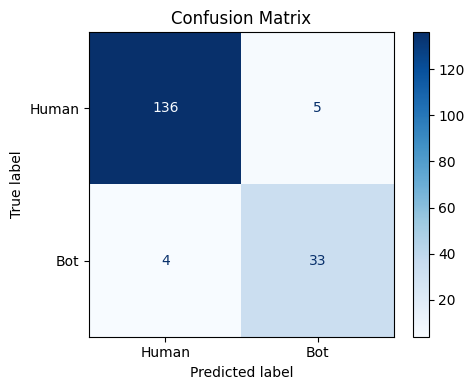

In [20]:
# y_pred from threshold 0.260

print("=== Classification Report ===\n")
print(classification_report(y_test, y_pred, target_names=["Human", "Bot"]))

print("\n=== Confusion Matrix ===\n")
cm = confusion_matrix(y_test, y_pred)
print(cm)

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(cm, display_labels=["Human", "Bot"]).plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [21]:
# Probabilities for wrong predictions (misclassified samples)
wrong_mask = y_pred != y_test
wrong_indices = np.where(wrong_mask)[0]
if len(wrong_indices) > 0:
    wrong_df = pd.DataFrame({
        "true_label": y_test.iloc[wrong_indices].values,
        "pred_label": y_pred[wrong_indices],
        "P(bot)": y_proba[wrong_indices],
    })
    wrong_df["true_label"] = wrong_df["true_label"].map({0: "Human", 1: "Bot"})
    wrong_df["pred_label"] = wrong_df["pred_label"].map({0: "Human", 1: "Bot"})
    wrong_df = wrong_df.sort_values("P(bot)")
    print("Wrong predictions (true vs predicted) and P(bot):")
    display(wrong_df)
    print(f"\nTotal wrong: {len(wrong_indices)}")
else:
    print("No wrong predictions.")

Wrong predictions (true vs predicted) and P(bot):


,true_label,pred_label,P(bot)
1,Bot,Human,0.011861
0,Bot,Human,0.045146
2,Bot,Human,0.059909
7,Bot,Human,0.092210
8,Human,Bot,0.345896
5,Human,Bot,0.354517
3,Human,Bot,0.409656
4,Human,Bot,0.585476
6,Human,Bot,0.906803



Total wrong: 9


In [22]:
# Compare feature data: humans predicted as bots vs average of humans predicted as human
human_pred_as_bot = (y_test.values == 0) & (y_pred == 1)
human_pred_as_human = (y_test.values == 0) & (y_pred == 0)
bot_pred_as_bot = (y_test.values == 1) & (y_pred == 1)
fp_indices = np.where(human_pred_as_bot)[0]
tn_indices = np.where(human_pred_as_human)[0]
tp_indices = np.where(bot_pred_as_bot)[0]

avg_human_correct = X_test.iloc[tn_indices].mean()
avg_bot_correct = X_test.iloc[tp_indices].mean() if len(tp_indices) > 0 else None
X_fp = X_test.iloc[fp_indices]

comp = pd.DataFrame({"avg(human→human)": avg_human_correct})
if avg_bot_correct is not None:
    comp["avg(bot→bot)"] = avg_bot_correct
if len(fp_indices) > 0:
    comp["avg(human→bot)"] = X_fp.mean()
    comp["diff"] = comp["avg(human→bot)"] - comp["avg(human→human)"]
    denom_h = comp["avg(human→human)"]
    comp["rel_diff_vs_human_%"] = np.where(denom_h != 0, 100 * (comp["avg(human→bot)"] - denom_h) / denom_h, 0)
    if avg_bot_correct is not None:
        denom_b = comp["avg(bot→bot)"]
        comp["rel_diff_vs_bot_%"] = np.where(denom_b != 0, 100 * (comp["avg(human→bot)"] - denom_b) / denom_b, 0)
        comp["|rel_human%|−|rel_bot%|"] = comp["rel_diff_vs_human_%"].abs() - comp["rel_diff_vs_bot_%"].abs()
    for i, idx in enumerate(fp_indices):
        comp[f"FP_{i+1}"] = X_test.iloc[idx]
    print("Feature comparison: avg(human→human), avg(bot→bot), vs humans wrongly predicted as bot")
    print("rel_diff_% = 100 × (avg(human→bot) − reference) / reference; |rel_human%|−|rel_bot%| = difference of those absolute %%\n")
else:
    print("No humans were predicted as bots.")
comp = comp.round(4)
comp = comp.drop(labels=[f"hour_{i}" for i in range(24)], errors="ignore")
display(comp)

Feature comparison: avg(human→human), avg(bot→bot), vs humans wrongly predicted as bot
rel_diff_% = 100 × (avg(human→bot) − reference) / reference; |rel_human%|−|rel_bot%| = difference of those absolute %%



,avg(human→human),avg(bot→bot),avg(human→bot),diff,rel_diff_vs_human_%,rel_diff_vs_bot_%,|rel_human%|−|rel_bot%|,FP_1,FP_2,FP_3,FP_4,FP_5
post_count,24.5882,39.6364,19.6000,-4.9882,-20.2871,-50.5505,-30.2634,37.0000,19.0000,14.0000,13.0000,15.0000
avg_text_length,112.1473,129.2548,143.4429,31.2955,27.9057,10.9768,16.9289,177.3243,158.5789,105.3571,104.1538,171.8000
unique_langs,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
has_url_ratio,0.5276,0.2201,0.5459,0.0182,3.4558,147.9642,-144.5083,0.6757,0.0526,0.7857,0.6154,0.6000
avg_post_gap_seconds,9255.9625,68858.8220,9569.4780,313.5156,3.3872,-86.1028,-82.7156,4459.8889,6033.9444,12940.4615,12307.1667,12105.9286
levenshtein_name_dist,11.3897,9.4848,11.0000,-0.3897,-3.4216,15.9744,-12.5529,8.0000,5.0000,19.0000,8.0000,15.0000
digit_density,0.0841,0.0899,0.1591,0.0750,89.1694,76.8819,12.2875,0.0000,0.5455,0.0000,0.2500,0.0000
iat_entropy,1.7615,2.7652,2.2999,0.5384,30.5658,-16.8249,13.7409,1.8463,1.0975,2.9689,2.7516,2.8352
burstiness,0.2685,0.0799,0.1924,-0.0761,-28.3610,140.8569,-112.4959,0.3575,0.4040,0.0892,0.0571,0.0539
lang_mismatch_ratio,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Feature Importance

In [23]:
# Posts from humans the model predicted as bots (false positives)
human_pred_as_bot = (y_test == 0) & (y_pred == 1)
fp_indices = np.where(human_pred_as_bot)[0]
fp_author_ids = set(test_df.iloc[fp_indices]["author_id"])

# Build author_id -> posts from the loaded posts list
by_author = {}
for p in posts:
    aid = p["author_id"]
    if aid in fp_author_ids:
        by_author.setdefault(aid, []).append(p)

if by_author:
    print(f"Humans predicted as bots: {len(by_author)}")
    for author_id in test_df.iloc[fp_indices]["author_id"].unique():
        author_posts = by_author.get(author_id, [])
        author_posts.sort(key=lambda x: x["created_at"])
        print(f"\n--- author_id: {author_id} ({len(author_posts)} posts) ---")
        for i, p in enumerate(author_posts[:20], 1):  # cap at 20 per user
            print(f"  [{i}] {p['created_at']} | {p['text'][:120]}{'...' if len(p['text']) > 120 else ''}")
        if len(author_posts) > 20:
            print(f"  ... and {len(author_posts) - 20} more posts")
else:
    print("No humans were predicted as bots.")

Humans predicted as bots: 1

--- author_id: 958d59eb-d757-a49f-b4b4-b24ff8d663bd (0 posts) ---

--- author_id: 497d65d3-e9d3-9ac7-a39d-68dd37b2aff6 (0 posts) ---

--- author_id: d7c8f328-3015-ac88-bda6-d68dbe334ef7 (0 posts) ---

--- author_id: a631924c-c9cf-8c3c-9765-22d19171baa3 (13 posts) ---
  [1] 2024-03-16T06:48:05.000Z | it's always so funny when ghost fans drag sleep token...
BITCH COLESLAW VS POTATO SALAD 😭😭
  [2] 2024-03-16T06:51:39.000Z | like... both of us aren't taken seriously in the metal community... instead of being at each other's throats we should c...
  [3] 2024-03-16T07:30:20.000Z | i need to be called "my love" immediately otherwise i'll DIE !!!
  [4] 2024-03-16T20:27:04.000Z | i have a new 10...
i've been listening to this so much it feels like my brain is melting but in the best possible way ht...
  [5] 2024-03-17T00:48:14.000Z | spent all day putting my album ratings into AOTY &amp; i think i got most of them. i need to relisten to some of them to...
  [6] 2024

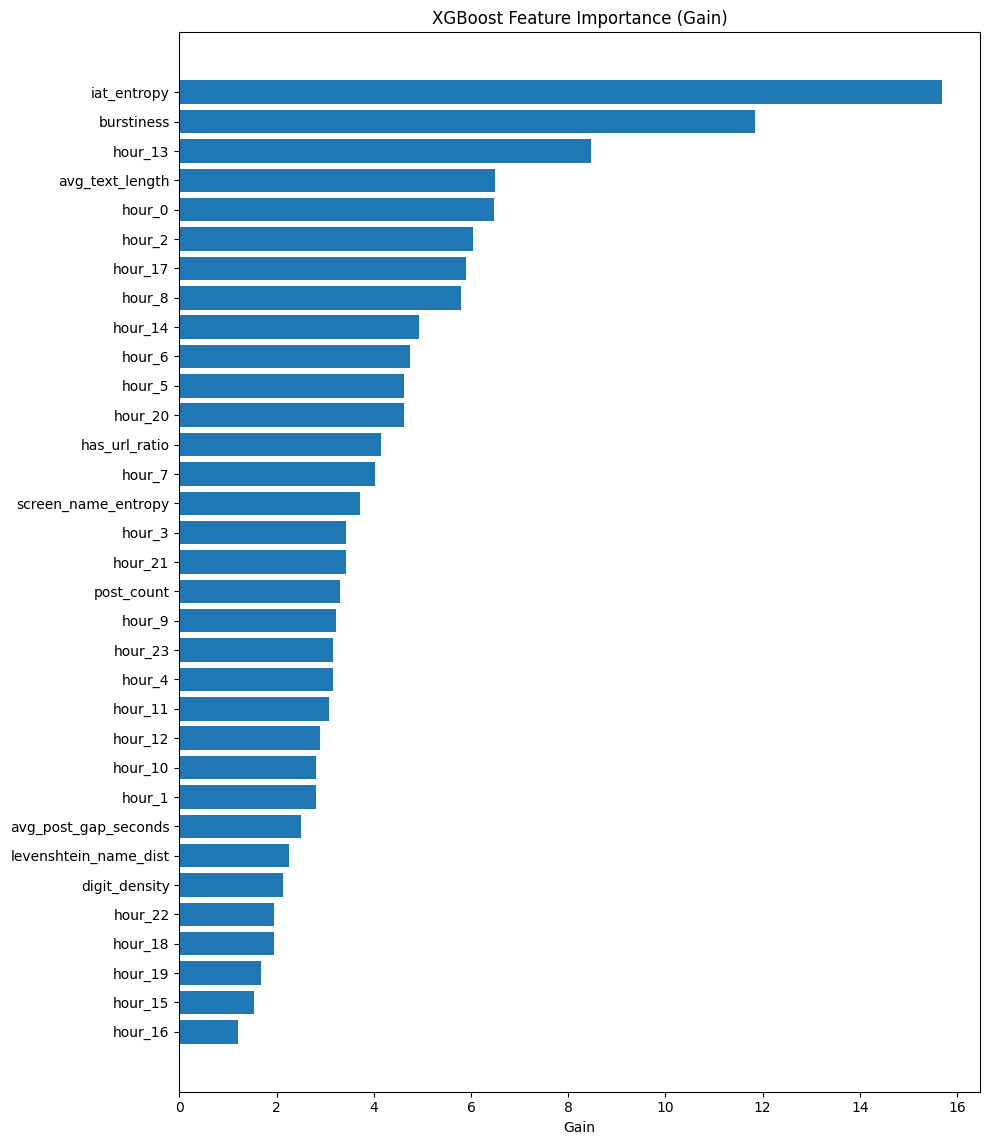

In [24]:
# Feature importance (gain-based); use full feature names
importances = model.get_booster().get_score(importance_type="gain")
# Map booster names (e.g. f0, f1) to actual column names
name_map = {f"f{i}": feature_cols[i] for i in range(len(feature_cols))}
imp_df = (
    pd.DataFrame({"feature": importances.keys(), "importance": importances.values()})
    .sort_values("importance", ascending=True)
)
imp_df["feature"] = imp_df["feature"].map(lambda x: name_map.get(x, x))

fig, ax = plt.subplots(figsize=(10, max(4, len(imp_df) * 0.35)))
ax.barh(imp_df["feature"], imp_df["importance"])
ax.set_xlabel("Gain")
ax.set_title("XGBoost Feature Importance (Gain)")
plt.subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

In [25]:
# === Export OOF XGBoost leaf features for BotRGCN ===
# K-Fold CV: each user's leaf indices come from a model that never saw
# that user during training — prevents transductive leakage in the GNN.

import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

os.makedirs("rgcn_features", exist_ok=True)

K_OOF, RANDOM_STATE, N_TREES = 5, 42, 150

export_df = combined_df.drop_duplicates(subset=["author_id"], keep="first").reset_index(drop=True)
X_export = export_df[feature_cols].fillna(0)
y_export = export_df["is_bot"].values

xgb_leaf_oof = np.zeros((len(export_df), N_TREES), dtype=np.float32)
skf = StratifiedKFold(n_splits=K_OOF, shuffle=True, random_state=RANDOM_STATE)

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_export, y_export), 1):
    fold_scale = (y_export[tr_idx] == 0).sum() / max(y_export[tr_idx].sum(), 1)
    fold_model = xgb.XGBClassifier(
        n_estimators=N_TREES, max_depth=4, learning_rate=0.1,
        scale_pos_weight=fold_scale, colsample_bytree=0.5,
        eval_metric="logloss", random_state=RANDOM_STATE,
    )
    fold_model.fit(X_export.iloc[tr_idx], y_export[tr_idx])
    xgb_leaf_oof[val_idx] = fold_model.apply(X_export.iloc[val_idx]).astype(np.float32)
    print(f"Fold {fold}: {len(val_idx)} users")

xgb_feature_vectors = MinMaxScaler().fit_transform(xgb_leaf_oof).astype(np.float32)

np.savez_compressed(
    "rgcn_features/xgb_features.npz",
    author_ids=export_df["author_id"].values,
    xgb_feature_vectors=xgb_feature_vectors,
    is_bot=export_df["is_bot"].values,
    train_user_ids=train_df["author_id"].unique(),
)
print(f"\nSaved OOF leaf features: {xgb_feature_vectors.shape} → rgcn_features/xgb_features.npz")

Fold 1: 178 users
Fold 2: 178 users
Fold 3: 178 users
Fold 4: 178 users
Fold 5: 177 users

Saved OOF leaf features: (889, 150) → rgcn_features/xgb_features.npz
